In [1]:
%load_ext autoreload
%autoreload 2    
# Autoreload isn't working for the ssg stuff,
# unclear why, I think it has too many layers of imports.

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time
from functools import reduce 
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

import pydrake
import tensorflow
import torch
import torch.distributions.constraints as constraints
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
import pyro
import pyro.distributions as dist
from pyro.contrib.autoname import scope

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.torch_utils import *
from spatial_scene_grammars.neural_grammar_proposal import *

from spatial_scene_grammars_examples.planar_box_stacks_complex.grammar import *

In [2]:
root_inst_dict = {"xy": dist.Normal(torch.tensor([0., 0.]), torch.tensor([0.001, 0.001]))}
grammar = SceneGrammar(Ground, root_inst_dict)

class RegeneratingObservedEnvDataset(Dataset):
    def __init__(self, grammar, project=True):
        super().__init__()
        # Detach the grammar, as we don't need any gradients.
        # TODO: make this a grammar func
        self.grammar = deepcopy(grammar)
        self.project = project
        for k, v in self.grammar.default_params.items():
            v.set_unconstrained(v.get_unconstrained_value().detach())

    def __len__(self):
        return 100
    
    def __getitem__(self, idx):
        success = False
        if self.project is True:
            constraints = [NonpenetrationConstraint(0.001)]
        else:
            constraints = []
        while not success:
            scene_trees, success = sample_tree_from_grammar_with_constraints(
                self.grammar,
                constraints=constraints,
                max_num_attempts=1000,
                backend="rejection",#"metropolis_procedural_modeling",
            )
        return scene_trees[0], [n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)]

class PregeneratedObservedEnvDataset(Dataset):
    def __init__(self, grammar, project=True, N=100):
        super().__init__()
        # Detach the grammar, as we don't need any gradients.
        # TODO: make this a grammar func
        self.N = N
        self.project = project
        self.grammar = deepcopy(grammar)
        for k, v in self.grammar.default_params.items():
            v.set_unconstrained(v.get_unconstrained_value().detach())
        self.scene_trees = []
        self.observed_nodes = []
        for k in range(self.N):
            tree, nodes = self.make_env()
            self.scene_trees.append(tree)
            self.observed_nodes.append(nodes)
            
    def make_env(self):
        success = False
        if self.project is True:
            constraints = [NonpenetrationConstraint(0.001)]
        else:
            constraints = []
        while not success:
            scene_trees, success = sample_tree_from_grammar_with_constraints(
                self.grammar,
                constraints=constraints,
                max_num_attempts=1000,
                backend="rejection",#"metropolis_procedural_modeling",
            )
        return scene_trees[0], [n for n in scene_trees[0].nodes if isinstance(n, TerminalNode)]
        
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return self.scene_trees[idx], self.observed_nodes[idx]
        
dynamic_dataset = RegeneratingObservedEnvDataset(grammar, project=True)

def load_pregen_dataset(N, prefix):
    # Pregenerated dataset: pregen once, save out.
    dataset_path = "pregen_dataset_%s_%d.torch" % (prefix, N)
    if not os.path.exists(dataset_path):
        print("Generating dataset %s..." % (dataset_path))
        dataset = PregeneratedObservedEnvDataset(grammar, project=True, N=N)
        torch.save(dataset, dataset_path)
        print("Saved dataset to %s" % dataset_path)
    else:
        print("Loading dataset from %s" % dataset_path)
        dataset = torch.load(dataset_path)
    return dataset

train_dataset = load_pregen_dataset(10000, "train")
val_dataset = load_pregen_dataset(300, "val")

def collate_fn(x):
    return list(y[0] for y in x), list(y[1] for y in x)
train_data_loader = DataLoader(train_dataset, num_workers=0, collate_fn=collate_fn, batch_size=300)
val_data_loader = DataLoader(val_dataset, num_workers=0, collate_fn=collate_fn, batch_size=300)
dynamic_data_loader = DataLoader(dynamic_dataset, num_workers=0, collate_fn=collate_fn, batch_size=300)
start_time = time.time()
observed_trees_for_test, observed_nodes_for_test = [list(x) for x in iter(train_data_loader).next()]
elapsed = time.time() - start_time
print("Sampled %d envs in %f secs = %f/sec" % (
    len(observed_trees_for_test), elapsed, len(observed_trees_for_test)/elapsed)
)

Loading dataset from pregen_dataset_train_10000.torch
Loading dataset from pregen_dataset_val_300.torch
Sampled 300 envs in 0.000546 secs = 549712.188729/sec


Start vec:  tensor([0., 0., 0., 0., 1., 0., 0., 0.])
Stop vec:  tensor([0., 0., 0., 0., 0., 1., 0., 0.])
X shape:  torch.Size([300, 10, 8])
Z shape:  torch.Size([300, 192])
X recon shape:  torch.Size([300, 10, 8])
Out of range entry at 1, 1
Out of range entry at 1, 2
Out of range entry at 1, 3
Out of range entry at 1, 4
Out of range entry at 1, 5
Out of range entry at 1, 7
Out of range entry at 1, 8
Out of range entry at 1, 9
Out of range entry at 2, 0
Out of range entry at 2, 1
Out of range entry at 2, 4
Out of range entry at 2, 6
Out of range entry at 2, 7
Out of range entry at 2, 8
Out of range entry at 2, 9
Out of range entry at 3, 0
Out of range entry at 3, 2
Out of range entry at 3, 3
Out of range entry at 3, 4
Out of range entry at 3, 5
Out of range entry at 3, 6
Out of range entry at 4, 1
Out of range entry at 4, 3
Out of range entry at 4, 4
Out of range entry at 4, 5
Out of range entry at 4, 9
Out of range entry at 5, 0
Out of range entry at 5, 3
Out of range entry at 5, 4
Out

Out of range entry at 98, 1
Out of range entry at 98, 7
Out of range entry at 99, 2
Out of range entry at 99, 3
Out of range entry at 99, 4
Out of range entry at 99, 6
Out of range entry at 99, 9
Out of range entry at 100, 1
Out of range entry at 100, 3
Out of range entry at 100, 4
Out of range entry at 101, 0
Out of range entry at 101, 1
Out of range entry at 101, 3
Out of range entry at 101, 4
Out of range entry at 101, 8
Out of range entry at 102, 0
Out of range entry at 102, 1
Out of range entry at 102, 2
Out of range entry at 102, 9
Out of range entry at 103, 0
Out of range entry at 103, 2
Out of range entry at 103, 5
Out of range entry at 103, 9
Out of range entry at 104, 0
Out of range entry at 104, 1
Out of range entry at 104, 2
Out of range entry at 104, 6
Out of range entry at 104, 9
Out of range entry at 105, 0
Out of range entry at 105, 7
Out of range entry at 106, 1
Out of range entry at 106, 6
Out of range entry at 107, 3
Out of range entry at 107, 4
Out of range entry at

Out of range entry at 194, 3
Out of range entry at 194, 6
Out of range entry at 194, 8
Out of range entry at 194, 9
Out of range entry at 195, 2
Out of range entry at 195, 3
Out of range entry at 195, 4
Out of range entry at 195, 6
Out of range entry at 195, 8
Out of range entry at 196, 1
Out of range entry at 196, 2
Out of range entry at 196, 8
Out of range entry at 197, 2
Out of range entry at 197, 3
Out of range entry at 198, 2
Out of range entry at 198, 3
Out of range entry at 198, 5
Out of range entry at 199, 2
Out of range entry at 199, 4
Out of range entry at 199, 7
Out of range entry at 199, 8
Out of range entry at 200, 1
Out of range entry at 200, 3
Out of range entry at 201, 0
Out of range entry at 201, 3
Out of range entry at 201, 5
Out of range entry at 201, 9
Out of range entry at 202, 2
Out of range entry at 202, 4
Out of range entry at 203, 1
Out of range entry at 203, 4
Out of range entry at 203, 9
Out of range entry at 205, 0
Out of range entry at 205, 1
Out of range e

Out of range entry at 289, 3
Out of range entry at 290, 0
Out of range entry at 290, 3
Out of range entry at 290, 6
Out of range entry at 291, 2
Out of range entry at 291, 3
Out of range entry at 291, 5
Out of range entry at 291, 6
Out of range entry at 292, 3
Out of range entry at 292, 4
Out of range entry at 293, 0
Out of range entry at 293, 5
Out of range entry at 293, 7
Out of range entry at 294, 0
Out of range entry at 294, 4
Out of range entry at 295, 0
Out of range entry at 295, 2
Out of range entry at 295, 6
Out of range entry at 296, 3
Out of range entry at 296, 5
Out of range entry at 296, 6
Out of range entry at 296, 7
Out of range entry at 297, 1
Out of range entry at 297, 5
Out of range entry at 298, 7
Out of range entry at 299, 4
Out of range entry at 299, 6
Out of range entry at 299, 9
Top row should match middle row, but probably not bottom row


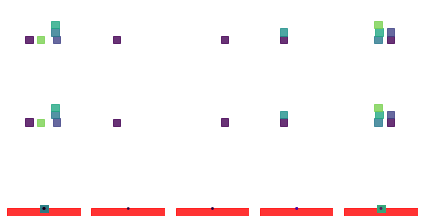

In [11]:
# Make node embedding units to encode / decode nodes to a fixed, common node embedding size.
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
class ObservedSceneAutoencoder(torch.nn.Module):
    '''
        Consumes an observed scene as a list of observed nodes
        from the specified grammar, and produces a fixed-size
        encoding vector for each observed scene.
        
        Observed set representation: Each observed node set is transformed
        into a PackedSequence of tensors, one for each node, which encode
        the node by concatenating its continuous variables (zero-padded to the
        max # of vars for any node) with a one-hot vector indicating the node type.
        Two additional node types ("start" and "stop") are added as additional
        one-hot slots.
        
        Encoding: Feed the PackedSequence into a GRU, and grab the output from
        the last iteration as the encoded "context" vector. (Borrowing terminology
        from seq2seq networks here.)
        
        Decoding: Create a GRU whose initial hidden state is the encoded context,
            and process its top GRU layer hidden state with a small densely connected
            network to produce a node fixed-size encoding (one-hot and variable regression).
            The first input is a "start" node, and every following input is the last
            output of the decoder.
    '''
    def __init__(self, grammar,
                 context_size=64,
                 num_layers=3):
        super().__init__()
        # Figure out what size the nodes need to be padded out to,
        # and the size of the one-hot encoding.
        self.unique_node_types = sorted(list(grammar.get_all_types_in_grammar()), key=lambda x: x.__class__.__name__)
        # Add "start" and "stop" symbols to node types
        self.num_node_types_without_extras = len(self.unique_node_types)
        self.num_node_types = len(self.unique_node_types) + 2
        self.start_symbol_offset = len(self.unique_node_types)
        self.stop_symbol_offset = len(self.unique_node_types) + 1
        
        self.node_type_to_index = {}
        self.node_type_to_num_vars = {}
        for k, node_type in enumerate(self.unique_node_types):
            self.node_type_to_index[node_type] = k
            self.node_type_to_num_vars[node_type] = node_type.get_num_continuous_variables()
        self.padded_node_var_size = max(self.node_type_to_num_vars.values())

        self.encoder_input_size = self.num_node_types + self.padded_node_var_size
        self.context_size = context_size
        self.num_layers = num_layers
        self.encoder = torch.nn.GRU(
            input_size=self.encoder_input_size,
            hidden_size=self.context_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        
        self.decoder_input_size = self.encoder_input_size
        # Offsets into decoder top-level hidden state
        self.decoder = torch.nn.GRU(
            input_size=self.decoder_input_size,
            hidden_size=self.context_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.decoder_common_head = torch.nn.Sequential(
            torch.nn.Linear(self.context_size, self.context_size),
            torch.nn.ReLU()
        )
        self.decoder_vars_head = torch.nn.Linear(self.context_size, self.padded_node_var_size)
        self.decoder_onehot_head = torch.nn.Sequential(
            torch.nn.Linear(self.context_size, self.num_node_types),
            torch.nn.Softmax()
        )
        

    def make_start_vec(self):
        stop_vec = torch.zeros(self.encoder_input_size, device=self.get_device())
        stop_vec[self.start_symbol_offset] = 1.
        return stop_vec

    def make_stop_vec(self):
        stop_vec = torch.zeros(self.encoder_input_size, device=self.get_device())
        stop_vec[self.stop_symbol_offset] = 1.
        return stop_vec
    
    def get_device(self):
        return self.encoder._flat_weights[0].device
        
    def pack_observed_nodes_batch(self, observed_nodes_batch):
        # Packs a list of lists of observed nodes (so a batch of observed scenes)
        # into a PackedSequence of encoded node sets.
        batch_size = len(observed_nodes_batch)
        seq_sizes = [len(x) for x in observed_nodes_batch]
        max_seq_size = max(seq_sizes)

        # Make input: for each node, make a one-hot vector of its
        # type, and concatenate with the node continuous vars, padded
        # out to a max length that fits all node types.
        xs = torch.zeros(batch_size, max_seq_size, self.encoder_input_size, device=self.get_device())
        for batch_k, nodes in enumerate(observed_nodes_batch):
            for k, node in enumerate(nodes):
                node_type = node.__class__
                index = self.node_type_to_index[node_type]
                n_vars = self.node_type_to_num_vars[node_type]
                # Make one-hot indicating the type.
                xs[batch_k, k, index] = 1.
                # Stick in the node variable valuesl.
                xs[batch_k, k, self.num_node_types:self.num_node_types + n_vars] = \
                    node.get_all_continuous_variables_as_vector()
        encoded_node_batches = pack_padded_sequence(xs, seq_sizes, batch_first=True, enforce_sorted=False)
        return encoded_node_batches
        
    def unpack_observed_nodes_batch(self, x):
        # Use pack_observed_nodes_batch to create the appropriate input.
        assert isinstance(x, PackedSequence)
        x_padded, seq_lens = pad_packed_sequence(x, batch_first=True)
        assert x_padded.shape[2] == self.encoder_input_size
        observed_nodes_batch = []
        
        for seq_k, (seq_len, vec) in enumerate(zip(seq_lens, x_padded)):
            nodes = []
            for node_k in range(seq_len):
                node_type_weights = vec[node_k, :][:self.num_node_types]
                if not torch.isclose(torch.sum(node_type_weights), torch.tensor(1.0)):
                    print("Bad entry at %d, %d" % (seq_k, node_k))
                    continue
                node_type = pyro.sample(
                    "unpack_%d_%d" % (seq_k, node_k),
                    dist.Categorical(node_type_weights)
                )
                if (node_type < self.num_node_types_without_extras):
                    node = self.unique_node_types[node_type].init_with_default_parameters()
                    node_vars = vec[node_k, :][self.num_node_types:]
                    derived, local = node.get_continuous_variables_from_vector(node_vars)
                    derived_variable_dists = {key: dist.Delta(val) for key,  val in derived.items()} 
                    local_variable_dists = {key: dist.Delta(val) for key,  val in local.items()}
                    node.instantiate(derived_variable_distributions=derived_variable_dists,
                                     local_variable_distributions_override=local_variable_dists)
                    nodes.append(node)
                else:
                    print("Out of range entry at %d, %d" % (seq_k, node_k))
            observed_nodes_batch.append(nodes)
        return observed_nodes_batch

    def encode(self, x):
        assert isinstance(x, PackedSequence)
        _, last_hidden = self.encoder(x)
        batch_size = last_hidden.shape[1]
        return last_hidden.permute([1, 2, 0]).reshape((batch_size, -1))

    def decode(self, z, target_x=None, max_n_objects=50, teacher_forcing=0.5):
        assert isinstance(z, torch.Tensor) and z.shape[1] == self.context_size * self.num_layers
        batch_size = z.shape[0]
        
        if target_x is not None:
            assert isinstance(target_x, PackedSequence)
            target_x, seq_sizes = pad_packed_sequence(target_x, batch_first=True)
            assert target_x.shape[0] == batch_size and target_x.shape[2] == self.encoder_input_size
            max_n_objects = torch.max(seq_sizes) + 1

        # Run GRU up to some max number of times to produce samples, feeding its output
        # back in as input, starting with the start vector.
        last_node_output = torch.empty((batch_size, 1, self.decoder_input_size), device=z.device)
        last_node_output[:, 0, :] = self.make_start_vec()
        hidden = z.reshape((batch_size, self.context_size, self.num_layers)).permute([2, 0, 1]).contiguous()
        output_steps = []
        for k in range(max_n_objects):
            # Single-step the GRU
            _, hidden = self.decoder(last_node_output, hidden)
            last_hidden = hidden[-1, ...]
            # Apply the regression heads to get the node prediction and calculate
            # the next input.
            common = self.decoder_common_head(last_hidden)
            node_choice = self.decoder_onehot_head(common)
            node_vars = self.decoder_vars_head(common)
            last_node_output = torch.cat([node_choice, node_vars], dim=-1)
            output_steps.append(last_node_output.clone())
            last_node_output = last_node_output.unsqueeze(1)
            
            if target_x is not None:
                last_node_output = target_x[:, k:k+1, :]
                # TODO: teacher forcing?
            else:
                # If all nodes are "stop", we can stop early.
                if torch.all(torch.argmax(node_choice, dim=1) == self.stop_symbol_offset):
                    break
        
        
        x = torch.stack(output_steps, dim=1) # batch_size x max_repeats x node encoding size    
        # If we have a target sequence, we need to have the same number of repeats as that
        # sequence, minimum.
        # Create an output PackedSequence by computing the number of actual repeats before
        # a "stop" in each output sequence.
        stops = (torch.argmax(x[:, :, :self.num_node_types], dim=-1) == self.stop_symbol_offset).int()
        ever_stopped, _ = torch.max(stops, dim=-1)
        num_repeats = torch.where(ever_stopped.bool(), torch.argmax(stops, dim=1), 
                                  torch.ones(batch_size, device=z.device).long()*max_n_objects)
        # We do need to clip all sequences to min length 1 to be able to pack, unfortunately.
        num_repeats = torch.clip(num_repeats, 1)
        # And if we have a target sequeunce, we need as many repeats as that target sequence,
        # even if it's multiple stops, to get training signal.
        if target_x is not None:
            num_repeats = torch.maximum(num_repeats.cpu(), seq_sizes + 1)
        
        return pack_padded_sequence(x, num_repeats.cpu(), batch_first=True, enforce_sorted=False)
    
test_scene_autoenc = ObservedSceneAutoencoder(grammar)
x = test_scene_autoenc.pack_observed_nodes_batch(observed_nodes_for_test)
print("Start vec: ", test_scene_autoenc.make_start_vec())
print("Stop vec: ", test_scene_autoenc.make_stop_vec())
z = test_scene_autoenc.encode(x)
x_recon = test_scene_autoenc.decode(z, target_x=None, max_n_objects=10)
#x_recon = test_scene_autoenc.decode(z, target_x=x)
print("X shape: ", pad_packed_sequence(x, batch_first=True)[0].shape)
print("Z shape: ", z.shape)
print("X recon shape: ", pad_packed_sequence(x_recon, batch_first=True)[0].shape)

def make_observed_to_tree(obs):
    tree = SceneTree()
    for obs_node in obs:
        tree.add_node(obs_node)
    return tree

observed_nodes_unpacked = test_scene_autoenc.unpack_observed_nodes_batch(x)
observed_nodes_autoencoded = test_scene_autoenc.unpack_observed_nodes_batch(x_recon)
N = 5
for k in range(N):
    plt.subplot(3, N, k+1)
    draw_boxes(make_observed_to_tree(observed_nodes_for_test[k]), fig=plt.gcf(), ax=plt.gca())
    plt.subplot(3, N, k+N+1)
    draw_boxes(make_observed_to_tree(observed_nodes_unpacked[k]), fig=plt.gcf(), ax=plt.gca())
    plt.subplot(3, N, k+N+N+1)
    draw_boxes(make_observed_to_tree(observed_nodes_autoencoded[k]), fig=plt.gcf(), ax=plt.gca())
plt.tight_layout()
print("Top row should match middle row, but probably not bottom row")

In [17]:
# Make sure we can train the node embeddings on their own.
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class AutoencoderTrainingModule(pl.LightningModule):
    def __init__(self, grammar):
        super().__init__()
        self.grammar = grammar
        self.context_size = 64
        self.scene_autoenc = ObservedSceneAutoencoder(
            grammar=grammar,
            context_size=self.context_size
        )

    def forward(self, observed_nodes_batch):
        x = self.scene_autoenc.pack_observed_nodes_batch(observed_nodes_batch)
        z = self.scene_autoenc.encode(x)
        x_pred = self.scene_autoenc.decode(z, target_x=x)
        return x, z, x_pred
        
    def compute_loss(self, x, x_pred):
        x_full, seq_lens = pad_packed_sequence(x, batch_first=True)
        x_pred_full, pred_seq_lens = pad_packed_sequence(x_pred, batch_first=True)

        # Up to the gt num_seqs, penalize error in the complete reconstructed x.
        overlap = min(x_full.shape[1], x_pred_full.shape[1])
        node_reconstruction_err = (x_full[:, :overlap, :] - x_pred_full[:, :overlap, :]).square().sum(dim=-1)
        # Above that, penalize error from the "stop" vector.
        stop_err = (x_pred_full - self.scene_autoenc.make_stop_vec()).square().sum(dim=-1)
        total_recon_loss = 0.
        total_stop_loss = 0.
        for batch_k, seq_len in enumerate(seq_lens):
            total_recon_loss = total_recon_loss + node_reconstruction_err[batch_k, :seq_len].sum()
            total_stop_loss = total_stop_loss + stop_err[batch_k, seq_len].sum()
        total_recon_loss = total_recon_loss / x_full.shape[0]
        total_stop_loss = total_stop_loss / x_full.shape[0]
        return total_recon_loss, total_stop_loss
        
    def training_step(self, batch, batch_idx):
        _, observed_nodes_batch = batch
        x, z, x_pred = self.forward(observed_nodes_batch)
        
        # Compute reconstruction loss
        recon_loss, stop_loss = self.compute_loss(x, x_pred)
        metrics = {"recon_loss": recon_loss, "stop_loss": stop_loss, "loss": recon_loss + stop_loss}
        self.log_dict(metrics)
        return (recon_loss + stop_loss)

    def validation_step(self, batch, batch_idx):
        _, observed_nodes_batch = batch
        x, z, x_pred = self.forward(observed_nodes_batch)
        
        # Compute reconstruction loss
        recon_loss, stop_loss = self.compute_loss(x, x_pred)
        metrics = {"val_recon_loss": recon_loss, "val_stop_loss": stop_loss, "val_loss": recon_loss + stop_loss}
        self.log_dict(metrics)
        
    def test_step(self, batch, batch_idx):
        _, observed_nodes_batch = batch
        x, z, x_pred = self.forward(observed_nodes_batch)
        
        # Compute reconstruction loss
        recon_loss, stop_loss = self.compute_loss(x, x_pred)
        metrics = {"test_recon_loss": recon_loss, "test_stop_loss": stop_loss, "test_loss": recon_loss + stop_loss}
        self.log_dict(metrics)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1E-2)
        return {
            "optimizer": optimizer,
            'lr_scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5),
            'monitor': 'loss'
        }
                                                  
    
retrain = False
autoenc_model = AutoencoderTrainingModule(grammar)
if retrain or not os.path.exists("saved_autoenc.ckpt"):
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    logger = TensorBoardLogger("tb_logs", name="target_env_autoenc")
    #logger = None
    #lr_monitor = None
    trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=250, callbacks=[lr_monitor, early_stopping],
                         gradient_clip_val=1.0, flush_logs_every_n_steps=5)
    trainer.fit(autoenc_model, train_data_loader, val_data_loader)
    trainer.test(test_dataloaders=dynamic_data_loader)
    trainer.save_checkpoint("saved_autoenc.ckpt")
else:
    autoenc_model = autoenc_model.load_from_checkpoint(checkpoint_path="saved_autoenc.ckpt", grammar=grammar)
    print("Loaded ", autoenc_model)

Loaded  AutoencoderTrainingModule(
  (grammar): SceneGrammar()
  (scene_autoenc): ObservedSceneAutoencoder(
    (encoder): GRU(8, 64, num_layers=3, batch_first=True)
    (decoder): GRU(8, 64, num_layers=3, batch_first=True)
    (decoder_common_head): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
    )
    (decoder_vars_head): Linear(in_features=64, out_features=2, bias=True)
    (decoder_onehot_head): Sequential(
      (0): Linear(in_features=64, out_features=6, bias=True)
      (1): Softmax(dim=None)
    )
  )
)


<class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'> <class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'>
<class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'> <class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'>
<class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'> <class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'>
<class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'> <class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'>
<class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'> <class 'spatial_scene_grammars_examples.planar_box_stacks_complex.grammar.Box'>


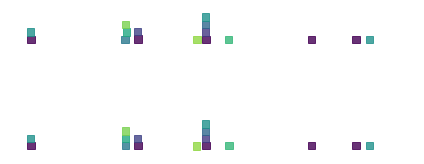

In [18]:
x = autoenc_model.scene_autoenc.pack_observed_nodes_batch(observed_nodes_for_test)
z = autoenc_model.scene_autoenc.encode(x)
x_recon = autoenc_model.scene_autoenc.decode(z)

observed_nodes_unpacked = autoenc_model.scene_autoenc.unpack_observed_nodes_batch(x)
observed_nodes_autoencoded = autoenc_model.scene_autoenc.unpack_observed_nodes_batch(x_recon)
N = 5
offset = 3
for k in range(N):
    plt.subplot(2, N, k+1)
    draw_boxes(make_observed_to_tree(observed_nodes_for_test[offset+k]), fig=plt.gcf(), ax=plt.gca())
    plt.subplot(2, N, k+N+1)
    draw_boxes(make_observed_to_tree(observed_nodes_autoencoded[offset+k]), fig=plt.gcf(), ax=plt.gca())
    print(type(observed_nodes_for_test[offset+k][0]), type(observed_nodes_autoencoded[offset+k][0]))
plt.tight_layout()

# Training the pilot network

Uses scene autoencoder to get a context vector for the environment.

For each node type, create an RNN that conditions on an instantiated node of that type + the full scene context, and produces a distribution over child nodes. The RNN output at each step is a (soft) one-hot output to select the output type from the node's list of child types, plus a "stop" symbol; and for each type, a vector of distribution parameters (gaussian mean field approx) for that node's derived and continuous attributes. The output node is sampled from that info, and the node details formed back into a vector and fed into the RNN as the next input in a seq2seq way.

Training examples 